<a href="https://colab.research.google.com/github/aruaru0/SAM-TEST/blob/main/Segmentation_Anything_Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インストール

In [1]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5jsbpnvi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5jsbpnvi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=16fb9b96929d7fd6ed4e425d7b8df92e38af2d0dc5c3fdcb72385bd03913605d
  Stored in directory: /tmp/pip-ephem-wheel-cache-o_4i88cl/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-26 11:43:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.250.75, 13.224.250.108, 13.224.250.114, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.2

# ヘルパー関数

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# 画像の読み込み

In [10]:
!wget -O cat2.png https://github.com/aruaru0/SAM-TEST/blob/main/cat2.png?raw=true

--2023-11-26 12:05:26--  https://github.com/aruaru0/SAM-TEST/blob/main/cat2.png?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aruaru0/SAM-TEST/raw/main/cat2.png [following]
--2023-11-26 12:05:26--  https://github.com/aruaru0/SAM-TEST/raw/main/cat2.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aruaru0/SAM-TEST/main/cat2.png [following]
--2023-11-26 12:05:26--  https://raw.githubusercontent.com/aruaru0/SAM-TEST/main/cat2.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638240 (623K) [image/png]
Sa

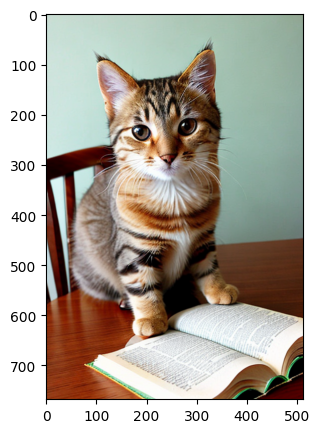

In [11]:
image = cv2.imread('cat2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

# 点を指定してセグメンテーション（複数マスク出力）

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

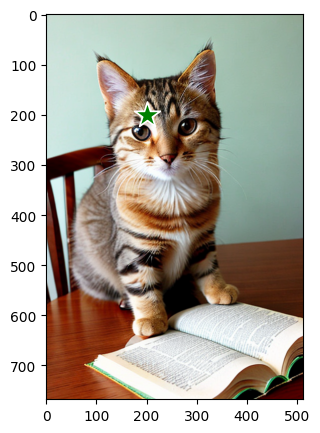

In [13]:
input_point = np.array([[200, 200]])
input_label = np.array([1])

plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [14]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

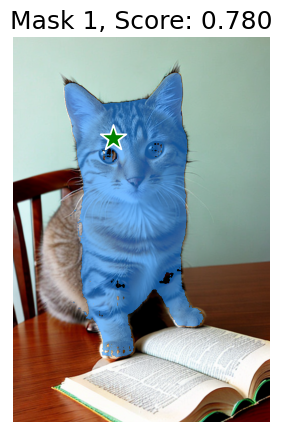

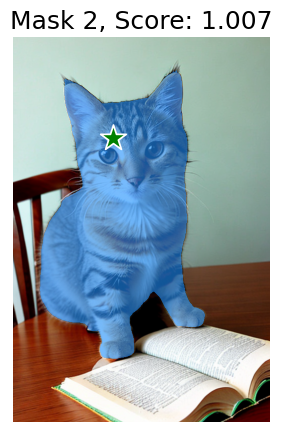

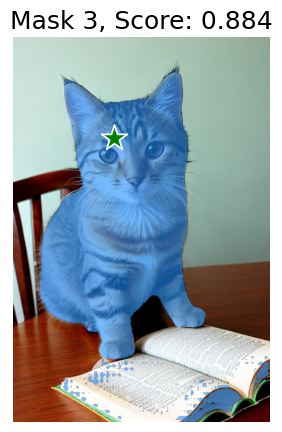

In [15]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## TIPS

In [27]:
best_mask = logits[np.argmax(scores), :, :]

In [32]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

# 点を指定してセグメンテーション（単一マスク出力）

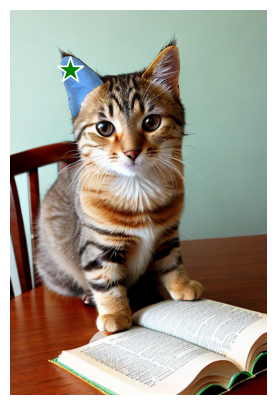

In [33]:
input_point = np.array([[120, 120]])
input_label = np.array([1])
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# 複数点を指定してセグメンテーション（単一マスク出力）

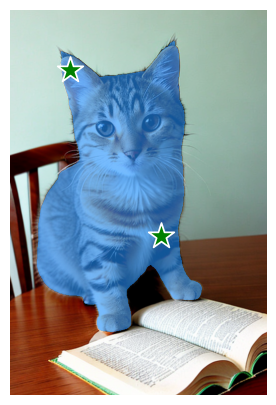

In [34]:
input_point = np.array([[120, 120], [300, 450]])
input_label = np.array([1, 1])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# 選択する点と、除外する点を指定してセグメンテーション

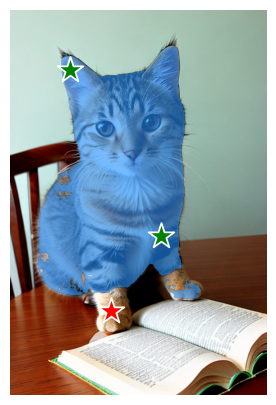

In [35]:
input_point = np.array([[120, 120], [300, 450], [200, 600]])
input_label = np.array([1, 1, 0])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# 矩形を指定してセグメンテーション

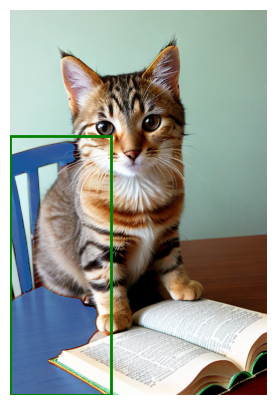

In [36]:
input_box = np.array([0, 250, 200, 768])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(5, 5))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

# 複数の矩形を指定してセグメンテーション

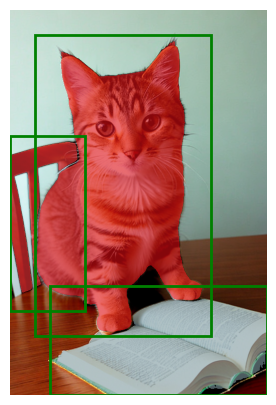

In [37]:
input_boxes = torch.tensor([
    [0, 250, 150, 600],
    [50, 50, 400, 650],
    [80, 550, 512, 768]
], device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(5, 5))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

# 矩形と点を組み合わせてセグメンテーション

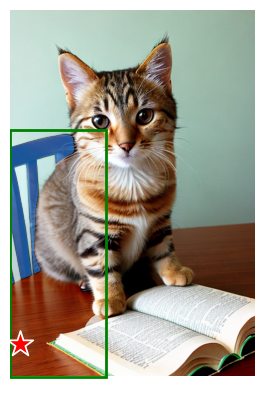

In [39]:
input_box = np.array([0, 250, 200, 768])
input_point = np.array([[20, 700]])
input_label = np.array([0])

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

plt.figure(figsize=(5, 5))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

# 画像全体を自動的にセグメンテーションする

## セグメンテーションを実行

In [44]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    pred_iou_thresh = 0.98,
    # points_per_side = 32,
)

masks = mask_generator_.generate(image)

print(len(masks))

12


## ヘルパー関数

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## 結果を表示

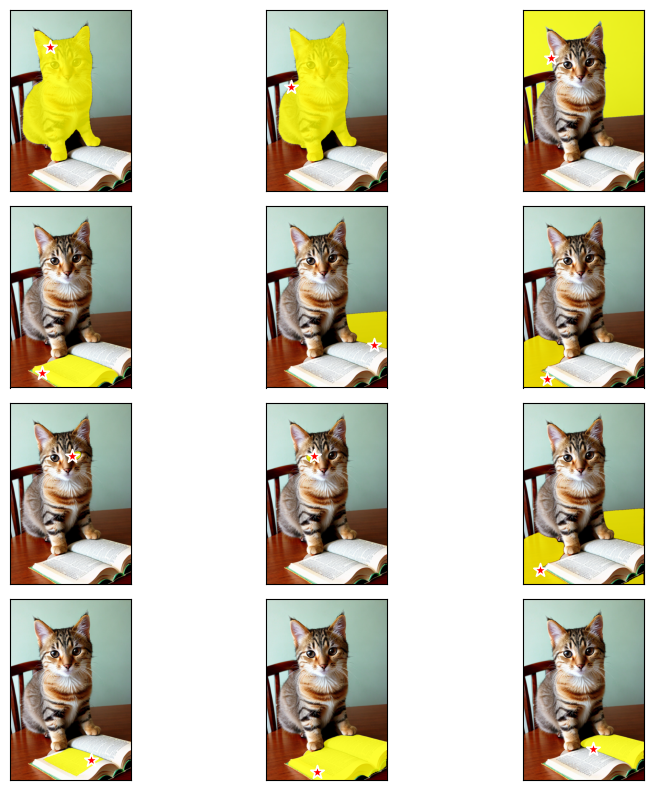

In [46]:
from torchvision.utils import draw_segmentation_masks

n = len(masks)
m = 3

flg, axes = plt.subplots(nrows = (n+m//2)//m, ncols = m, tight_layout=True, figsize=(3*m, 2*(n+m//2)//m))

for i in range(len(masks)) :
  img = torch.tensor(image).permute(2,0,1)
  mask =  torch.tensor(masks[i]['segmentation'])
  x = draw_segmentation_masks(img, mask, colors="yellow")

  axes[i//m, i%m].imshow(x.permute(1,2,0))
  axes[i//m, i%m].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  px, py = masks[i]['point_coords'][0]
  input_point = np.array([[int(px), int(py)]])
  input_label = np.array([0])
  show_points(input_point, input_label, axes[i//m, i%m], marker_size=100)
  # if i == 6 : break


plt.show()

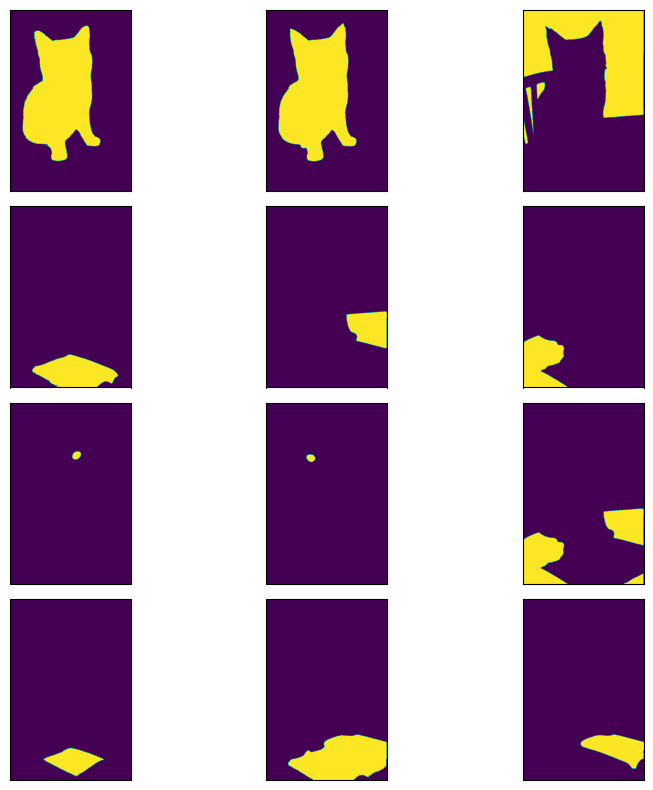

In [47]:

n = len(masks)
m = 3

flg, axes = plt.subplots(nrows = (n+m//2)//m, ncols = m, tight_layout=True, figsize=(3*m, 2*(n+m//2)//m))

for i in range(len(masks)) :
  x = torch.tensor(masks[i]['segmentation']).float()
  axes[i//m, i%m].imshow(x)
  axes[i//m, i%m].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
  # if i == 10 : break


plt.show()
